(384, 384, 3) (384, 384)


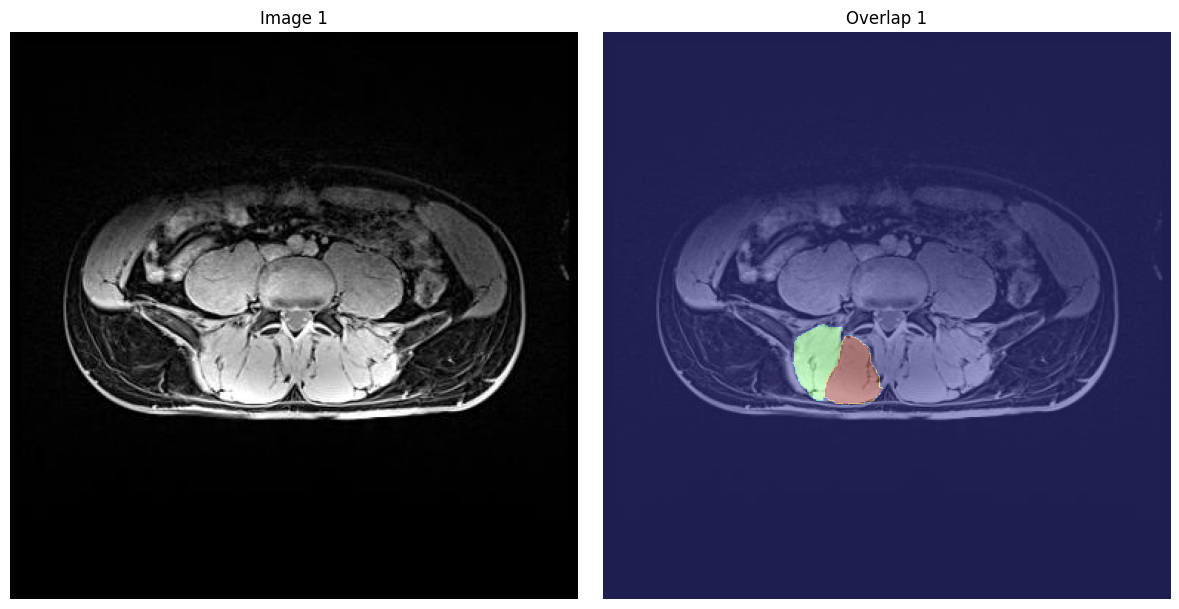

(384, 384, 3) (384, 384)


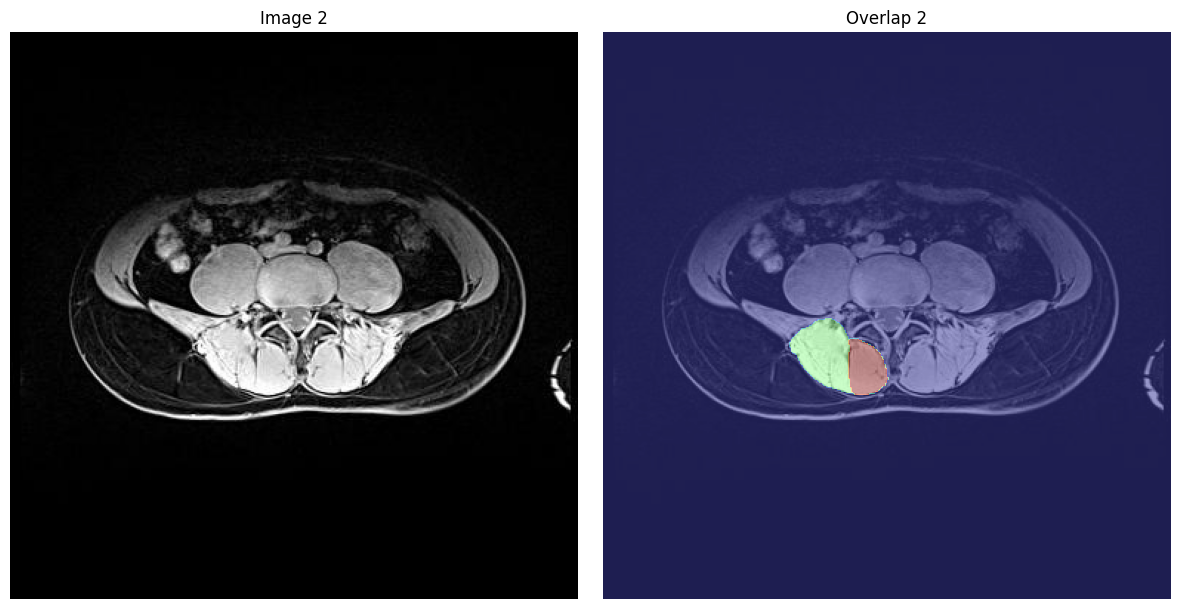

(384, 384, 3) (384, 384)


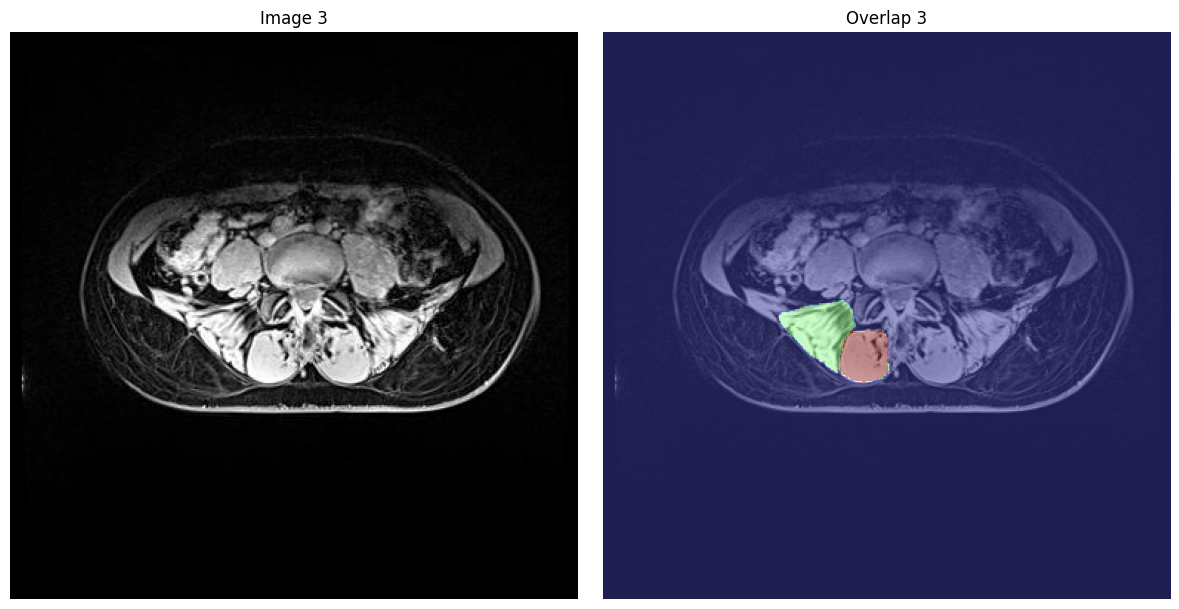

(384, 384, 3) (384, 384)


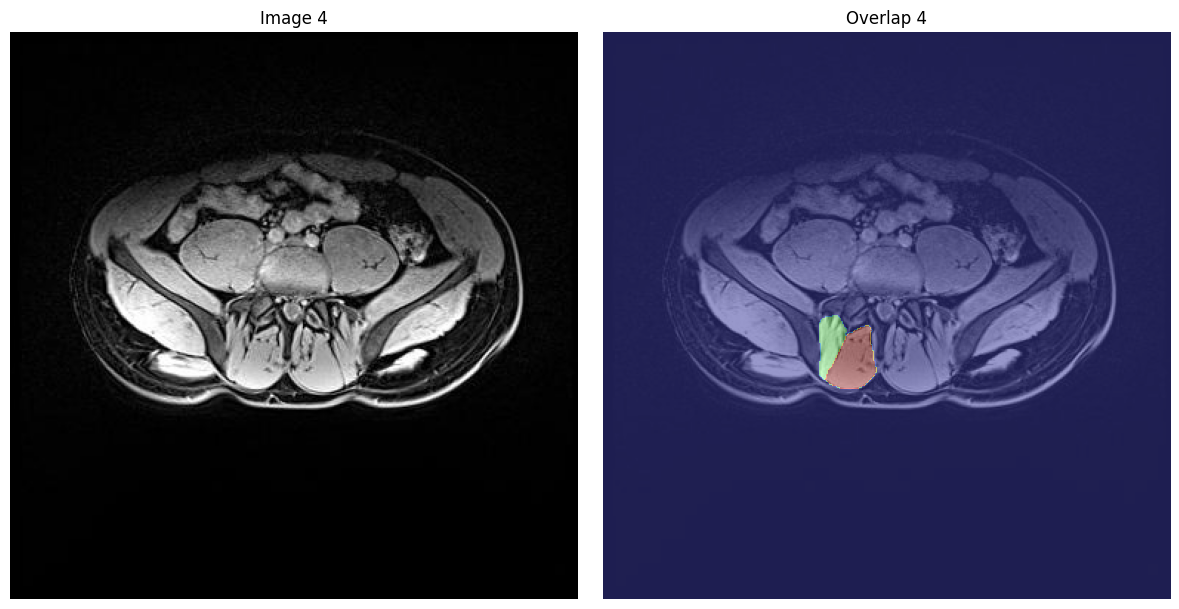

(384, 384, 3) (384, 384)


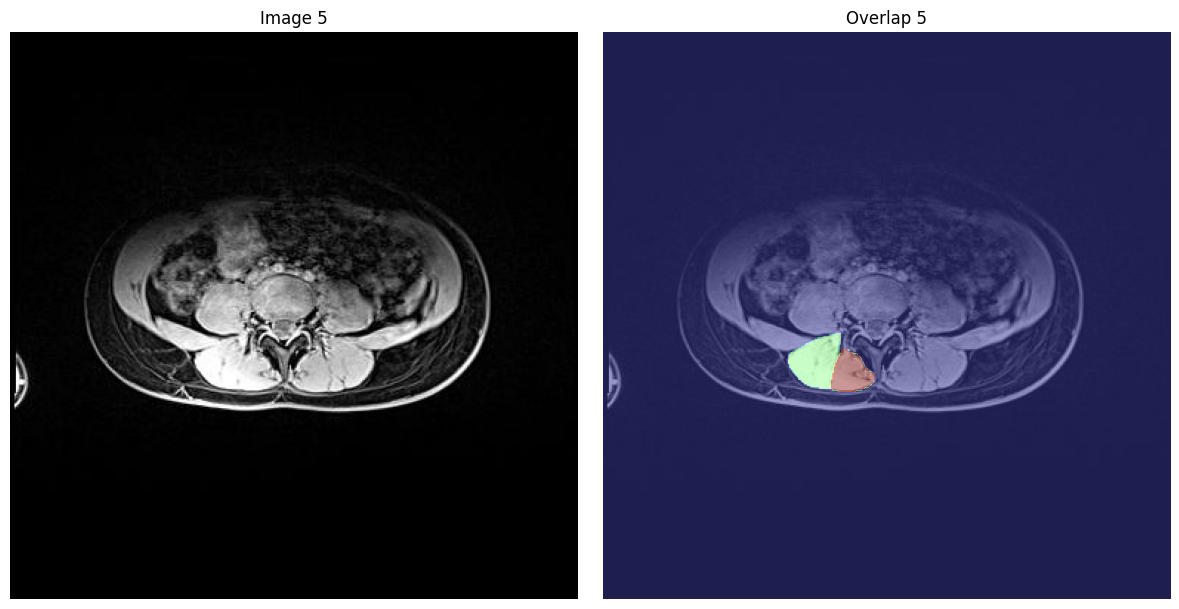

(384, 384, 3) (384, 384)


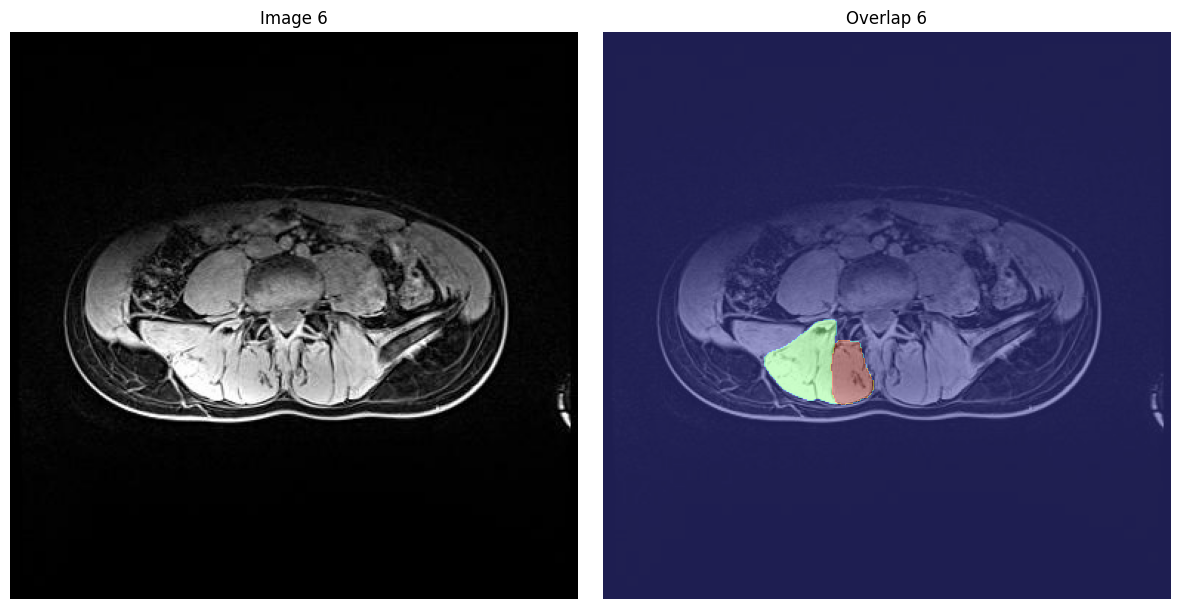

(384, 384, 3) (384, 384)


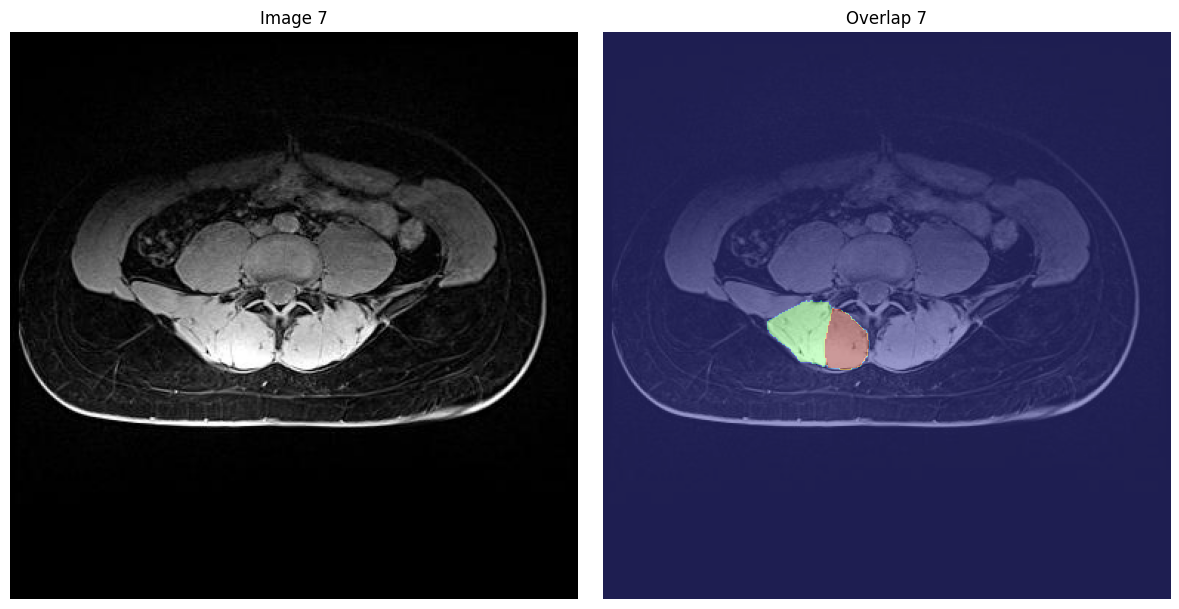

(384, 384, 3) (384, 384)


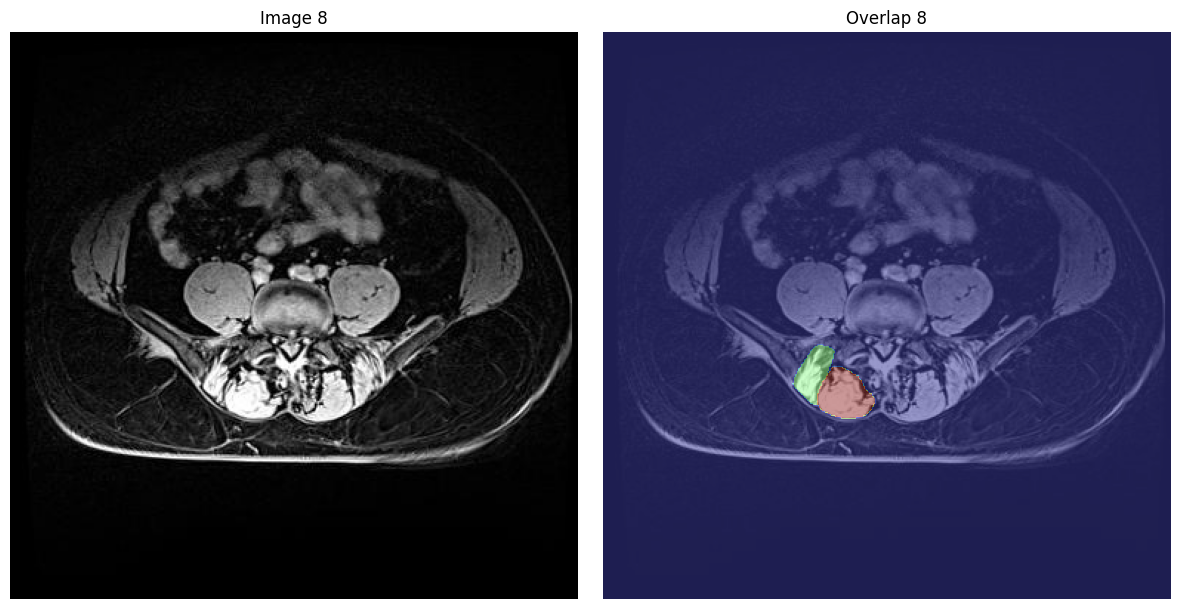

(384, 384, 3) (384, 384)


(384, 384, 3) (384, 384)


In [1]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# 数据目录路径
data_dir = './videos/bed_rest_MRI/Bedrest_L4L5_in_JPG_2class_overlap_ablation'
img_dir = os.path.join(data_dir, 'img_in_jpg_L4L5_renamed_ablation')
label_dir = os.path.join(data_dir, 'label_in_png_L4L5_renamed_ablation')


# 获取按 ID 排序的文件列表
img_files = sorted(os.listdir(img_dir), key=lambda x: int(x.split('.')[0]))

label_files = sorted(os.listdir(label_dir), key=lambda x: int(x.split('.')[0]))


# 检查文件数量是否匹配
if len(img_files) != len(label_files):
    raise ValueError("The number of images and labels does not match!")

# 遍历文件并绘制重叠图像
for idx, (img_file, label_file) in enumerate(zip(img_files, label_files)):
    # 构造文件路径
    img_path = os.path.join(img_dir, img_file)
    label_path = os.path.join(label_dir, label_file)
    
    # 加载图像和标签
    img = np.array(Image.open(img_path).convert("RGB"))  # 转换为 RGB 格式
    label = np.array(Image.open(label_path))  # 加载标签
    
    label = cv2.resize(
    label, 
    (img.shape[1], img.shape[0]),  # Note: (width, height)
    interpolation=cv2.INTER_NEAREST
    )
    
    print(img.shape, label.shape)
    # 绘制图像和重叠图
    plt.figure(figsize=(12, 6))
    
    # 子图 1: 原始图像
    plt.subplot(1, 2, 1)
    plt.title(f"Image {idx + 1}")
    plt.imshow(img)
    plt.axis('off')
    
    # 子图 2: 重叠图像
    plt.subplot(1, 2, 2)
    plt.title(f"Overlap {idx + 1}")
    plt.imshow(img, alpha=0.8)
    plt.imshow(label, cmap='jet', alpha=0.4)  # 使用透明度叠加标签
    plt.axis('off')
    
    # 显示绘图
    plt.tight_layout()
    plt.show()


In [2]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import cv2

# 设置路径
data_dir = './videos/bed_rest_MRI/Bedrest_L4L5_in_JPG_2class_overlap_ablation'
label_dir = os.path.join(data_dir, 'label_in_png_L4L5_renamed_ablation')
label_files = sorted(os.listdir(label_dir), key=lambda x: int(x.split('.')[0]))
print(label_files)

['00000.png', '00002.png', '00003.png', '00007.png', '00014.png', '00015.png', '00016.png', '00020.png', '00022.png', '00023.png']


# 更新一下代码，解释给我用中文，代码里的comment用英文：
每个frame_idx	对应一个manual label和两个auto seg，对应top_mask_select为1,2，每个label或者autoseg都有两个class。计算每个top_mask_select的dsc。还有计算每个top_mask_select两个class重叠区域的overlap-ratio，如果没有重叠区域，那么计算两个class的距离, 计算overlap-ratio和距离之前，先只选中largest component，之计算each class的largest component的overlap-ratio和距离。这个距离是指两个class的largest component的轮廓的有几个像素点那么远？

In [3]:
再更新一下代码，加点东西，多计算一下这些：因为我有两个备选的autoseg, top_mask_select为1,2，每个autoseg对应两个class(1,2),
所以一共有2个备选的class1 mask， 2个备选的calss2 mask，那么备选1的class1 mask和备选2的class2 mask， 
备选1的class2 mask和备选2的class1 mask，又可以组合成两个新的autoseg，
把这两个新的autoseg也计算一下dsc, largest component的overlap-ratio和距离


SyntaxError: invalid character '，' (U+FF0C) (2237813676.py, line 1)

In [4]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import cv2

# 设置路径
data_dir = './videos/bed_rest_MRI/Bedrest_L4L5_in_JPG_2class_overlap_ablation'
label_dir = os.path.join(data_dir, 'label_in_png_L4L5_renamed_ablation')
label_files = sorted(os.listdir(label_dir), key=lambda x: int(x.split('.')[0]))

# 初始化结果存储
results = []

# Function to calculate DSC (Dice Similarity Coefficient)
def calculate_dsc(mask1, mask2):
    """
    Calculate the Dice Similarity Coefficient (DSC) between two masks.
    """
    mask2 = cv2.resize(
        mask2, (mask1.shape[1], mask1.shape[0]), interpolation=cv2.INTER_NEAREST
    )
    intersection = np.sum((mask1 > 0) & (mask2 > 0))
    union = np.sum(mask1 > 0) + np.sum(mask2 > 0)
    return (2.0 * intersection / union) if union > 0 else 1.0

# Function to calculate overlap ratio and contour distance
def calculate_overlap_and_distance(mask1, mask2):
    """
    Calculate the overlap ratio between two masks. If there is no overlap,
    calculate the distance between the largest components' contours.
    """
    # Calculate intersection and total area
    intersection = np.sum((mask1 > 0) & (mask2 > 0))
    total_area = np.sum(mask1 > 0) + np.sum(mask2 > 0)
    overlap_ratio = intersection / total_area if total_area > 0 else 0.0

    # If there is overlap, return overlap_ratio and None for distance
    if intersection > 0:
        return overlap_ratio, None

    # Function to get the largest connected component
    def largest_component(binary_mask):
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
        largest_idx = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1 if num_labels > 1 else 0
        return (labels == largest_idx).astype(np.uint8)

    # Get largest components
    mask1_largest = largest_component(mask1)
    mask2_largest = largest_component(mask2)

    # Find contours for both masks
    contours1, _ = cv2.findContours(mask1_largest, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours2, _ = cv2.findContours(mask2_largest, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate minimum distances between contours
    distances = []
    for c1 in contours1:
        for c2 in contours2:
            for point1 in c1:
                for point2 in c2:
                    dist = np.linalg.norm(point1[0] - point2[0])
                    distances.append(dist)

    # Compute the average of the 10 smallest distances
    if distances:
        distances = sorted(distances)
        top_10_distances = distances[:10]
        avg_distance = np.mean(top_10_distances)
    else:
        avg_distance = float('inf')  # If no contours are found

    return overlap_ratio, avg_distance

# Helper function to find matching files
def find_matching_file(directory, prefix, suffix=".png"):
    """
    Find a file in the directory that matches the given prefix and suffix.
    """
    for file_name in os.listdir(directory):
        if file_name.startswith(prefix) and file_name.endswith(suffix):
            return os.path.join(directory, file_name)
    return None

# Loop through all files and combinations
for frame_idx, label_file in enumerate(label_files):
    if frame_idx == 0:
        continue

    label_path = os.path.join(label_dir, label_file)
    label_mask = np.array(Image.open(label_path))

    # Collect auto-segmentation masks for both top_mask_select values
    auto_seg_masks = []
    for top_mask_select in range(1, 3):
        auto_seg_dir = os.path.join(data_dir, f'SAM2_seg_mask_top_{top_mask_select}')
        if not os.path.exists(auto_seg_dir):
            print(f"Directory {auto_seg_dir} does not exist.")
            continue

        auto_seg_paths = [
            find_matching_file(auto_seg_dir, f"frame_{frame_idx}_obj_{i}", suffix=".png") for i in [1, 2]
        ]
        print(' auto_seg_paths of iou rank: ', top_mask_select, 'of frame idx', frame_idx)
        auto_masks = [np.array(Image.open(path)) for path in auto_seg_paths if path]
        if len(auto_masks) == 2:
            auto_seg_masks.append(auto_masks)

    # Ensure we have two sets of auto-segmentations
    if len(auto_seg_masks) != 2:
        print(f"Skipping frame {frame_idx} due to missing auto-segmentations.")
        continue

    # Generate all combinations
    combinations = [
        (auto_seg_masks[0][0], auto_seg_masks[0][1], 1, 1),  # Default combination 1
        (auto_seg_masks[1][0], auto_seg_masks[1][1], 2, 2),  # Default combination 2
        (auto_seg_masks[0][0], auto_seg_masks[1][1], 1, 2),  # Cross combination 1
        (auto_seg_masks[0][1], auto_seg_masks[1][0], 2, 1),  # Cross combination 2
    ]

    # Process each combination
    for mask1, mask2, top_mask_select_obj1, top_mask_select_obj2 in combinations:
        # Calculate metrics
        class1_dsc = calculate_dsc(label_mask == 50, mask1)
        class2_dsc = calculate_dsc(label_mask == 100, mask2)
        overlap_ratio, contour_distance = calculate_overlap_and_distance(mask1, mask2)

        # Append results
        results.append({
            "frame_idx": frame_idx,
            "obj1_iou_rank": top_mask_select_obj1,
            "obj2_iou_rank": top_mask_select_obj2,
            "label_file": label_file,
            "class1_dsc": class1_dsc,
            "class2_dsc": class2_dsc,
            "overlap_ratio": overlap_ratio,
            "contour_distance": contour_distance,
            "ave_dsc" : 0.5 *(class1_dsc + class2_dsc)
        })

# Save results to CSV
results_df = pd.DataFrame(results)
output_csv = os.path.join(data_dir, 'dsc_overlap_distance_combined_results.csv')
results_df.to_csv(output_csv, index=False)
print(f"Results saved to {output_csv}.")


 auto_seg_paths of iou rank:  1 of frame idx 1
 auto_seg_paths of iou rank:  2 of frame idx 1
 auto_seg_paths of iou rank:  1 of frame idx 2
 auto_seg_paths of iou rank:  2 of frame idx 2
 auto_seg_paths of iou rank:  1 of frame idx 3
 auto_seg_paths of iou rank:  2 of frame idx 3
 auto_seg_paths of iou rank:  1 of frame idx 4
 auto_seg_paths of iou rank:  2 of frame idx 4
 auto_seg_paths of iou rank:  1 of frame idx 5
 auto_seg_paths of iou rank:  2 of frame idx 5
 auto_seg_paths of iou rank:  1 of frame idx 6
 auto_seg_paths of iou rank:  2 of frame idx 6
 auto_seg_paths of iou rank:  1 of frame idx 7
 auto_seg_paths of iou rank:  2 of frame idx 7
 auto_seg_paths of iou rank:  1 of frame idx 8
 auto_seg_paths of iou rank:  2 of frame idx 8
 auto_seg_paths of iou rank:  1 of frame idx 9
 auto_seg_paths of iou rank:  2 of frame idx 9
Results saved to ./videos/bed_rest_MRI/Bedrest_L4L5_in_JPG_2class_overlap_ablation/dsc_overlap_distance_combined_results.csv.


In [5]:
results_df.head()

frame_idx  obj1_iou_rank  obj2_iou_rank label_file  class1_dsc  class2_dsc  \
0          1              1              1  00002.png    0.933630    0.944931   
1          1              2              2  00002.png    0.834825    0.943874   
2          1              1              2  00002.png    0.933630    0.943874   
3          1              2              1  00002.png    0.016979    0.000000   
4          2              1              1  00003.png    0.722391    0.874423   

   overlap_ratio  contour_distance   ave_dsc  
0       0.000000          2.153391  0.939281  
1       0.000000          1.870820  0.889350  
2       0.003286               NaN  0.938752  
3       0.000000          3.312014  0.008490  
4       0.000000          2.844425  0.798407

In [6]:
# Iterate and add obj1_iou and obj2_iou columns
obj1_ious = []
obj2_ious = []

for index, row in results_df.iterrows():
    obj1_val = None
    obj2_val = None

    for obj_id in [1, 2]:
        obj_col_str = f'obj{obj_id}_iou_rank'
        top_mask_pick = row[obj_col_str]
        seg_mask_dir = os.path.join(data_dir, f'SAM2_seg_mask_top_{top_mask_pick}')

        prefix = f'frame_{row["frame_idx"]}_obj_{obj_id}'
        suffix = '.png'
        targ_file_path = None

        if os.path.exists(seg_mask_dir):
            for file_name in os.listdir(seg_mask_dir):
                if file_name.startswith(prefix) and file_name.endswith(suffix):
                    targ_file_path = os.path.join(seg_mask_dir, file_name)
                    break

            if targ_file_path:
                val = np.float64(targ_file_path.split('_')[-1].split(".png")[0])
                if obj_id == 1:
                    obj1_val = val
                elif obj_id == 2:
                    obj2_val = val

    obj1_ious.append(obj1_val)
    obj2_ious.append(obj2_val)

# Add the new columns to results_df
results_df["obj1_iou"] = obj1_ious
results_df["obj2_iou"] = obj2_ious



In [7]:
results_df

frame_idx  obj1_iou_rank  obj2_iou_rank label_file  class1_dsc  \
0           1              1              1  00002.png    0.933630   
1           1              2              2  00002.png    0.834825   
2           1              1              2  00002.png    0.933630   
3           1              2              1  00002.png    0.016979   
4           2              1              1  00003.png    0.722391   
5           2              2              2  00003.png    0.788250   
6           2              1              2  00003.png    0.722391   
7           2              2              1  00003.png    0.008247   
8           3              1              1  00007.png    0.883766   
9           3              2              2  00007.png    0.720368   
10          3              1              2  00007.png    0.883766   
11          3              2              1  00007.png    0.234146   
12          4              1              1  00014.png    0.841584   
13          4              2              2  00014.png    0.707258   
14          4              1              2  00014.png    0.841584   
15          4              2              1  00014.png    0.617593   
16          5              1              1  00015.png    0.798819   
17          5              2              2  00015.png    0.572214   
18          5              1              2  00015.png    0.798819   
19          5              2              1  00015.png    0.201939   
20          6              1              1  00016.png    0.652772   
21          6              2              2  00016.png    0.633232   
22          6              1              2  00016.png    0.652772   
23          6              2              1  00016.png    0.246457   
24          7              1              1  00020.png    0.713472   
25          7              2              2  00020.png    0.678173   
26          7              1              2  00020.png    0.713472   
27          7              2              1  00020.png    0.001381   
28          8              1              1  00022.png    0.877603   
29          8              2              2  00022.png    0.560231   
30          8              1              2  00022.png    0.877603   
31          8              2              1  00022.png    0.159483   
32          9              1              1  00023.png    0.794643   
33          9              2              2  00023.png    0.685819   
34          9              1              2  00023.png    0.794643   
35          9              2              1  00023.png    0.228769   

    class2_dsc  overlap_ratio  contour_distance   ave_dsc  obj1_iou  obj2_iou  
0     0.944931       0.000000          2.153391  0.939281     0.915     0.915  
1     0.943874       0.000000          1.870820  0.889350     0.797     0.913  
2     0.943874       0.003286               NaN  0.938752     0.915     0.913  
3     0.000000       0.000000          3.312014  0.008490     0.797     0.915  
4     0.874423       0.000000          2.844425  0.798407     0.740     0.884  
5     0.852052       0.000000          2.307983  0.820151     0.704     0.875  
6     0.852052       0.000000          3.029667  0.787221     0.740     0.875  
7     0.000000       0.000000          2.225141  0.004124     0.704     0.884  
8     0.825856       0.134747               NaN  0.854811     0.800     0.800  
9     0.870712       0.000000          2.877810  0.795540     0.474     0.781  
10    0.870712       0.068070               NaN  0.877239     0.800     0.781  
11    0.000000       0.045423               NaN  0.117073     0.474     0.800  
12    0.587595       0.369361               NaN  0.714590     0.725     0.725  
13    0.586416       0.416524               NaN  0.646837     0.485     0.705  
14    0.586416       0.365540               NaN  0.714000     0.725     0.705  
15    0.464471       0.421498               NaN  0.541032     0.485     0.725  
16    0.797569       0.005417               NaN  0.79

In [8]:
max_rows = results_df.loc[results_df.groupby('frame_idx')['ave_dsc'].idxmax()]

# Calculate differences with additional columns
differences = []
for frame_idx, group in results_df.groupby('frame_idx'):
    # Get the max row for the current frame_idx
    max_row = max_rows[max_rows['frame_idx'] == frame_idx].iloc[0]
    
    # Get the row where obj1_iou_rank and obj2_iou_rank are both 1
    ref_row = group[(group['obj1_iou_rank'] == 1) & (group['obj2_iou_rank'] == 1)]
    if not ref_row.empty:
        ref_row = ref_row.iloc[0]
        # Calculate differences
        diff_overlap = max_row['overlap_ratio'] - ref_row['overlap_ratio']
        diff_obj1_iou = max_row['obj1_iou'] - ref_row['obj1_iou']
        diff_obj2_iou = max_row['obj2_iou'] - ref_row['obj2_iou']
        diff_ave_dsc = max_row['ave_dsc'] - ref_row['ave_dsc']
        differences.append({
            "frame_idx": frame_idx,
            "max_obj1_iou_rank": max_row['obj1_iou_rank'],
            "max_obj2_iou_rank": max_row['obj2_iou_rank'],
            "max_ave_dsc": max_row['ave_dsc'],
            "ref_ave_dsc": ref_row['ave_dsc'],
            "diff_ave_dsc": diff_ave_dsc,
            "diff_overlap_ratio": diff_overlap,
            "diff_obj1_iou": diff_obj1_iou,
            "diff_obj2_iou": diff_obj2_iou
        })

# Create a DataFrame to display the differences
differences_df = pd.DataFrame(differences)
differences_df


frame_idx  max_obj1_iou_rank  max_obj2_iou_rank  max_ave_dsc  ref_ave_dsc  \
0          1                  1                  1     0.939281     0.939281   
1          2                  2                  2     0.820151     0.798407   
2          3                  1                  2     0.877239     0.854811   
3          4                  1                  1     0.714590     0.714590   
4          5                  1                  1     0.798194     0.798194   
5          6                  1                  2     0.788274     0.741042   
6          7                  1                  1     0.788131     0.788131   
7          8                  1                  2     0.900073     0.863435   
8          9                  1                  2     0.862578     0.782987   

   diff_ave_dsc  diff_overlap_ratio  diff_obj1_iou  diff_obj2_iou  
0      0.000000            0.000000          0.000          0.000  
1      0.021744            0.000000         -0.036         -0.009  
2      0.022428           -0.066677          0.000         -0.019  
3      0.000000            0.000000          0.000          0.000  
4      0.000000            0.000000          0.000          0.000  
5      0.047232            0.000000          0.000         -0.100  
6      0.000000            0.000000          0.000          0.000  
7      0.036638           -0.037619          0.000         -0.149  
8      0.079591           -0.005785          0.000         -0.010

In [9]:
results_df

frame_idx  obj1_iou_rank  obj2_iou_rank label_file  class1_dsc  \
0           1              1              1  00002.png    0.933630   
1           1              2              2  00002.png    0.834825   
2           1              1              2  00002.png    0.933630   
3           1              2              1  00002.png    0.016979   
4           2              1              1  00003.png    0.722391   
5           2              2              2  00003.png    0.788250   
6           2              1              2  00003.png    0.722391   
7           2              2              1  00003.png    0.008247   
8           3              1              1  00007.png    0.883766   
9           3              2              2  00007.png    0.720368   
10          3              1              2  00007.png    0.883766   
11          3              2              1  00007.png    0.234146   
12          4              1              1  00014.png    0.841584   
13          4              2              2  00014.png    0.707258   
14          4              1              2  00014.png    0.841584   
15          4              2              1  00014.png    0.617593   
16          5              1              1  00015.png    0.798819   
17          5              2              2  00015.png    0.572214   
18          5              1              2  00015.png    0.798819   
19          5              2              1  00015.png    0.201939   
20          6              1              1  00016.png    0.652772   
21          6              2              2  00016.png    0.633232   
22          6              1              2  00016.png    0.652772   
23          6              2              1  00016.png    0.246457   
24          7              1              1  00020.png    0.713472   
25          7              2              2  00020.png    0.678173   
26          7              1              2  00020.png    0.713472   
27          7              2              1  00020.png    0.001381   
28          8              1              1  00022.png    0.877603   
29          8              2              2  00022.png    0.560231   
30          8              1              2  00022.png    0.877603   
31          8              2              1  00022.png    0.159483   
32          9              1              1  00023.png    0.794643   
33          9              2              2  00023.png    0.685819   
34          9              1              2  00023.png    0.794643   
35          9              2              1  00023.png    0.228769   

    class2_dsc  overlap_ratio  contour_distance   ave_dsc  obj1_iou  obj2_iou  
0     0.944931       0.000000          2.153391  0.939281     0.915     0.915  
1     0.943874       0.000000          1.870820  0.889350     0.797     0.913  
2     0.943874       0.003286               NaN  0.938752     0.915     0.913  
3     0.000000       0.000000          3.312014  0.008490     0.797     0.915  
4     0.874423       0.000000          2.844425  0.798407     0.740     0.884  
5     0.852052       0.000000          2.307983  0.820151     0.704     0.875  
6     0.852052       0.000000          3.029667  0.787221     0.740     0.875  
7     0.000000       0.000000          2.225141  0.004124     0.704     0.884  
8     0.825856       0.134747               NaN  0.854811     0.800     0.800  
9     0.870712       0.000000          2.877810  0.795540     0.474     0.781  
10    0.870712       0.068070               NaN  0.877239     0.800     0.781  
11    0.000000       0.045423               NaN  0.117073     0.474     0.800  
12    0.587595       0.369361               NaN  0.714590     0.725     0.725  
13    0.586416       0.416524               NaN  0.646837     0.485     0.705  
14    0.586416       0.365540               NaN  0.714000     0.725     0.705  
15    0.464471       0.421498               NaN  0.541032     0.485     0.725  
16    0.797569       0.005417               NaN  0.79

In [15]:
import pandas as pd


# Define the selection process for each frame_idx
selected_rows = []
for frame_idx, group in results_df.groupby('frame_idx'):
    # Get the max iou
    max_iou = max(group['obj1_iou'].max(), group['obj2_iou'].max())
    
    # Filter options where no iou is less than max_iou - 0.1
    candidates = group[
        (group['obj1_iou'] >= max_iou - 0.1) & 
        (group['obj2_iou'] >= max_iou - 0.1)
    ]
    
    if not candidates.empty:
        # Check overlap_ratio condition and select the best
        max_iou_row = group[(group['obj1_iou'] == max_iou) | (group['obj2_iou'] == max_iou)].iloc[0]
        max_overlap_ratio = max_iou_row['overlap_ratio']
        
        filtered_candidates = candidates[
            (candidates['overlap_ratio'] > 0) & 
            (candidates['overlap_ratio'] < max_overlap_ratio - 0.05)
        ]
        
        # If filtered candidates are available, select the one with the highest iou
        if not filtered_candidates.empty:
            best_row = filtered_candidates.loc[
                filtered_candidates[['obj1_iou', 'obj2_iou']].max(axis=1).idxmax()
            ]
        else:
            # If overlap_ratio == 0, select the one with the minimum contour distance
            zero_overlap_candidates = candidates[candidates['overlap_ratio'] == 0]
            if len(zero_overlap_candidates) >= 2:
                best_row = zero_overlap_candidates.loc[
                    zero_overlap_candidates['contour_distance'].idxmin()
                ]
            else:
                best_row = max_iou_row
    else:
        best_row = group.iloc[0]  # Fallback to any row if no candidates
    
    selected_rows.append(best_row)
    
# Calculate the average ave_dsc for the original df and the selected_df
selected_df = pd.DataFrame(selected_rows)

original_ave_dsc_mean = results_df['ave_dsc'].mean()
selected_ave_dsc_mean = selected_df['ave_dsc'].mean()

# Calculate the difference
dsc_difference = selected_ave_dsc_mean - original_ave_dsc_mean

# Print the results
print(f"Difference in ave_dsc: {dsc_difference}")
selected_df


Difference in ave_dsc: 0.1977848855277633


frame_idx  obj1_iou_rank  obj2_iou_rank label_file  class1_dsc  \
0           1              1              1  00002.png    0.933630   
4           2              1              1  00003.png    0.722391   
10          3              1              2  00007.png    0.883766   
12          4              1              1  00014.png    0.841584   
16          5              1              1  00015.png    0.798819   
20          6              1              1  00016.png    0.652772   
24          7              1              1  00020.png    0.713472   
28          8              1              1  00022.png    0.877603   
33          9              2              2  00023.png    0.685819   

    class2_dsc  overlap_ratio  contour_distance   ave_dsc  obj1_iou  obj2_iou  
0     0.944931       0.000000          2.153391  0.939281     0.915     0.915  
4     0.874423       0.000000          2.844425  0.798407     0.740     0.884  
10    0.870712       0.068070               NaN  0.877239     0.800     0.781  
12    0.587595       0.369361               NaN  0.714590     0.725     0.725  
16    0.797569       0.005417               NaN  0.798194     0.717     0.717  
20    0.829313       0.000000          1.289949  0.741042     0.594     0.882  
24    0.862789       0.018303               NaN  0.788131     0.334     0.819  
28    0.849267       0.037619               NaN  0.863435     0.616     0.822  
33    0.930514       0.000000          6.414635  0.808166     0.606     0.684

In [14]:
results_df

frame_idx  obj1_iou_rank  obj2_iou_rank label_file  class1_dsc  \
0           1              1              1  00002.png    0.933630   
1           1              2              2  00002.png    0.834825   
2           1              1              2  00002.png    0.933630   
3           1              2              1  00002.png    0.016979   
4           2              1              1  00003.png    0.722391   
5           2              2              2  00003.png    0.788250   
6           2              1              2  00003.png    0.722391   
7           2              2              1  00003.png    0.008247   
8           3              1              1  00007.png    0.883766   
9           3              2              2  00007.png    0.720368   
10          3              1              2  00007.png    0.883766   
11          3              2              1  00007.png    0.234146   
12          4              1              1  00014.png    0.841584   
13          4              2              2  00014.png    0.707258   
14          4              1              2  00014.png    0.841584   
15          4              2              1  00014.png    0.617593   
16          5              1              1  00015.png    0.798819   
17          5              2              2  00015.png    0.572214   
18          5              1              2  00015.png    0.798819   
19          5              2              1  00015.png    0.201939   
20          6              1              1  00016.png    0.652772   
21          6              2              2  00016.png    0.633232   
22          6              1              2  00016.png    0.652772   
23          6              2              1  00016.png    0.246457   
24          7              1              1  00020.png    0.713472   
25          7              2              2  00020.png    0.678173   
26          7              1              2  00020.png    0.713472   
27          7              2              1  00020.png    0.001381   
28          8              1              1  00022.png    0.877603   
29          8              2              2  00022.png    0.560231   
30          8              1              2  00022.png    0.877603   
31          8              2              1  00022.png    0.159483   
32          9              1              1  00023.png    0.794643   
33          9              2              2  00023.png    0.685819   
34          9              1              2  00023.png    0.794643   
35          9              2              1  00023.png    0.228769   

    class2_dsc  overlap_ratio  contour_distance   ave_dsc  obj1_iou  obj2_iou  
0     0.944931       0.000000          2.153391  0.939281     0.915     0.915  
1     0.943874       0.000000          1.870820  0.889350     0.797     0.913  
2     0.943874       0.003286               NaN  0.938752     0.915     0.913  
3     0.000000       0.000000          3.312014  0.008490     0.797     0.915  
4     0.874423       0.000000          2.844425  0.798407     0.740     0.884  
5     0.852052       0.000000          2.307983  0.820151     0.704     0.875  
6     0.852052       0.000000          3.029667  0.787221     0.740     0.875  
7     0.000000       0.000000          2.225141  0.004124     0.704     0.884  
8     0.825856       0.134747               NaN  0.854811     0.800     0.800  
9     0.870712       0.000000          2.877810  0.795540     0.474     0.781  
10    0.870712       0.068070               NaN  0.877239     0.800     0.781  
11    0.000000       0.045423               NaN  0.117073     0.474     0.800  
12    0.587595       0.369361               NaN  0.714590     0.725     0.725  
13    0.586416       0.416524               NaN  0.646837     0.485     0.705  
14    0.586416       0.365540               NaN  0.714000     0.725     0.705  
15    0.464471       0.421498               NaN  0.541032     0.485     0.725  
16    0.797569       0.005417               NaN  0.79

In [12]:
# Calculate the difference in ave_dsc between selected_df and the (1, 1) row for each frame_idx
differences = []
for frame_idx, group in results_df.groupby('frame_idx'):
    # Get the selected row for this frame_idx
    selected_row = selected_df[selected_df['frame_idx'] == frame_idx].iloc[0]
    
    # Get the reference row where obj1_iou_rank and obj2_iou_rank are both 1
    ref_row = group[(group['obj1_iou_rank'] == 1) & (group['obj2_iou_rank'] == 1)]
    
    if not ref_row.empty:
        ref_row = ref_row.iloc[0]
        diff_ave_dsc = selected_row['ave_dsc'] - ref_row['ave_dsc']
        differences.append({
            "frame_idx": frame_idx,
            "selected_ave_dsc": selected_row['ave_dsc'],
            "ref_ave_dsc": ref_row['ave_dsc'],
            "diff_ave_dsc": diff_ave_dsc
        })

# Create a DataFrame for the differences
differences_df = pd.DataFrame(differences)
differences_df


frame_idx  selected_ave_dsc  ref_ave_dsc  diff_ave_dsc
0          1          0.939281     0.939281      0.000000
1          2          0.798407     0.798407      0.000000
2          3          0.877239     0.854811      0.022428
3          4          0.714590     0.714590      0.000000
4          5          0.798194     0.798194      0.000000
5          6          0.741042     0.741042      0.000000
6          7          0.788131     0.788131      0.000000
7          8          0.863435     0.863435      0.000000
8          9          0.808166     0.782987      0.025179